In [ ]:
import blankly
from blankly import (
    Strategy,
    StrategyState,
    Interface,
    Alpaca,
    PaperTrade,
    trunc,
)
from blankly.indicators import sma
from arima_model import ArimaStrategy

TICKERS = ["NWS", "NWSA"]
PERIOD = "1M"
RESOLUTION = "1d"
BENCHMARK = "SPY"
TRADE_ON = "open"
CARRY_FORWARD_PREVIOUS_DECISION = False
PCT_BALANCE_TO_TRADE = 0.25
DEPLOY = True


def init(symbols, state: StrategyState):
    # initialize this once and store it into state
    variables = state.variables

    # get precision of the symbols
    increment = next(product['base_increment']
                     for product in state.interface.get_products()
                     if product['symbol'] == symbols[0])
    variables["precision"] = blankly.utils.increment_to_precision(increment)

    # Download price data to give context to the algo
    # This gets the past 150 data points prior to the start of the backtest
    # Data kept as a deque to reduce memory usage
    # keys: ['high', 'low', 'volume', 'close', 'open', 'time']
    variables["x_history"] = state.interface.history(
        symbols[0], to=50, return_as="deque", resolution=RESOLUTION
    )[TRADE_ON]
    variables["y_history"] = state.interface.history(
        symbols[1], to=50, return_as="deque", resolution=RESOLUTION
    )[TRADE_ON]

    variables["model"] = ArimaStrategy(variables["x_history"], variables["y_history"])

    variables["prev_long_decision"] = (0, 0)
    variables["prev_short_decision"] = (0, 0)
    variables["prev_decision"] = (0, 0)

    variables["cash"] = []
    variables["x_position"]= [state.interface.account[symbols[0]].available]
    variables["y_position"]= [state.interface.account[symbols[1]].available]
    variables["x_fee"] = [] 
    variables["y_fee"] = []


def teardown(symbols, state: StrategyState):

    # close all positions
    interface: Interface = state.interface
    variables = state.variables

    # close all positions
    curr_x_unit = interface.account[symbols[0]].available
    curr_y_unit = interface.account[symbols[1]].available

    # truncate to precision
    curr_x_unit = trunc(curr_x_unit, variables["precision"])
    curr_y_unit = trunc(curr_y_unit, variables["precision"])

    if curr_x_unit > 0:
        interface.market_order(symbols[0], "sell", curr_x_unit)
    elif curr_x_unit < 0:
        interface.market_order(symbols[0], "buy", abs(curr_x_unit))

    if curr_y_unit > 0:
        interface.market_order(symbols[1], "sell", curr_y_unit)
    elif curr_y_unit < 0:
        interface.market_order(symbols[1], "buy", abs(curr_y_unit))



    variables["cash"].append(interface.cash)
    variables["x_position"].append(interface.account[symbols[0]].available)
    variables["y_position"].append(interface.account[symbols[1]].available)
    variables["x_fee"].append(interface.get_fees(symbols[0]))
    variables["y_fee"].append(interface.get_fees(symbols[1]))
    logs = variables
    
    # write as pickle
    import pickle
    with open('logs.pkl', 'wb') as f:
        pickle.dump(logs, f)




def price_event(prices, symbols, state: StrategyState):

    interface: Interface = state.interface
    variables = state.variables
    model: ArimaStrategy = variables["model"]
    x_data_point = prices[symbols[0]]
    y_data_point = prices[symbols[1]]

    # make a decision to buy, sell, or hold
    # returns decision: 1 for long, -1 for short, 0 for close position
    pred_beta, long_decision, short_decision = model.make_decision(
        x_data_point,
        y_data_point,
    )

    # if we are carrying forward the previous decision, then we need to check if the current decision is None
    if CARRY_FORWARD_PREVIOUS_DECISION:
        if long_decision == (None, None):
            long_decision = variables["prev_long_decision"]
        if short_decision == (None, None):
            short_decision = variables["prev_short_decision"]
    else:
        if long_decision == (None, None):
            long_decision = (0, 0)
        if short_decision == (None, None):
            short_decision = (0, 0)

    decision = (
        long_decision[0] + short_decision[0],
        long_decision[1] + short_decision[1],
    )

    # if today's decision is different from yesterday's, then we need to close our position first
    if variables["prev_decision"] != decision:
        # close all positions
        curr_x_unit = interface.account[symbols[0]].available 
        curr_y_unit = interface.account[symbols[1]].available

        # truncate to precision
        curr_x_unit = trunc(curr_x_unit, variables["precision"])
        curr_y_unit = trunc(curr_y_unit, variables["precision"])

        if curr_x_unit > 0:
            interface.market_order(symbols[0], "sell", curr_x_unit)
        elif curr_x_unit < 0:
            interface.market_order(symbols[0], "buy", abs(curr_x_unit))

        if curr_y_unit > 0:
            interface.market_order(symbols[1], "sell", curr_y_unit)
        elif curr_y_unit < 0:
            interface.market_order(symbols[1], "buy", abs(curr_y_unit))
    
    variables["prev_long_decision"] = long_decision
    variables["prev_short_decision"] = short_decision
    variables["prev_decision"] = decision

    cash_available = interface.cash * PCT_BALANCE_TO_TRADE
    curr_x_unit = interface.account[symbols[0]].available
    curr_y_unit = interface.account[symbols[1]].available

    # indicates whether we are buying or selling
    sign_x = decision[0]
    sign_y = decision[1]

    # since alpaca does not allow fractional shorting, we need to make the stock being shorter a whole number
    # we do this by making the other (long) stock a fraction of the shorted stock
    if sign_x < 0 and sign_y > 0:
        # if we are shorting x, then we need to make y a fraction of x
        target_x_unit = (cash_available // x_data_point) * sign_x
        target_y_unit = abs(target_x_unit) / pred_beta * sign_y
    elif sign_y < 0 and sign_x > 0:
        # if we are shorting y, then we need to make x a fraction of y
        target_y_unit = (cash_available // y_data_point) * sign_y
        target_x_unit = abs(target_y_unit) * pred_beta * sign_x
    elif sign_x == 0 and sign_y == 0:
        # if we are closing our position, then we need to make both x and y 0
        target_x_unit = 0
        target_y_unit = 0

    # calculate the difference between the current and target units
    x_diff = target_x_unit - curr_x_unit
    y_diff = target_y_unit - curr_y_unit

    # truncate to precision
    x_diff = trunc(x_diff, variables["precision"])
    y_diff = trunc(y_diff, variables["precision"])

    if x_diff > 0:
        interface.market_order(symbols[0], "buy", x_diff)
    elif x_diff < 0:
        interface.market_order(symbols[0], "sell", abs(x_diff))

    if y_diff > 0:
        interface.market_order(symbols[1], "buy", y_diff)
    elif y_diff < 0:
        interface.market_order(symbols[1], "sell", abs(y_diff))

    variables["x_history"].append(x_data_point)
    variables["y_history"].append(y_data_point)
    variables["cash"].append(interface.cash)
    variables["x_position"].append(interface.account[symbols[0]].available)
    variables["y_position"].append(interface.account[symbols[1]].available)
    variables["x_fee"].append(interface.get_fees(symbols[0]))
    variables["y_fee"].append(interface.get_fees(symbols[1]))

    # update model
    model.update(x_data_point, y_data_point)


if __name__ == "__main__":
    # Basic exchange construction
    alpaca = Alpaca(portfolio_name="alpaca_test")

    # Create a paper trade exchange (local paper trading)
    alpaca_paper_trade = PaperTrade(alpaca)

    # Create a strategy
    strategy = Strategy(alpaca_paper_trade)

    # [x, y]
    strategy.add_arbitrage_event(price_event, TICKERS, resolution=RESOLUTION, init=init, teardown=teardown)
    if DEPLOY:
        print("Deploying strategy...")
        strategy.start()
    else:
        strategy.add_prices(BENCHMARK, resolution=RESOLUTION, to=PERIOD)
        res = strategy.backtest(
            initial_values={"USD": 10000},
            to=PERIOD,
            use_price="open",
            show_progress=True,
            risk_free_return_rate=0.00,
            benchmark_symbol=BENCHMARK,
        )


In [22]:
# read pickle
import pickle
with open('arima_logs.pkl', 'rb') as f:
    logs: dict = pickle.load(f)

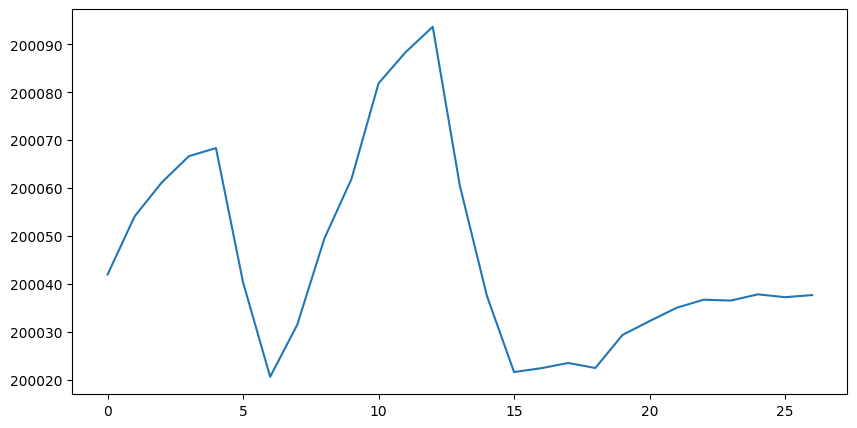

In [23]:
import matplotlib.pyplot as plt
plt.ticklabel_format(useOffset=False)
plt.plot(logs.cash)
plt.show()